# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:10:35.590035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:10:35.590097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:10:35.591633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-3, who has ID: A21U4DR8M6I9QN

In [2]:
parameters = {}

user = "users-3"
user_id = "A21U4DR8M6I9QN"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A1SYLII0808HD6,B00006IX59,B000084F4A,B0002H3ZDA
1,A1SYLII0808HD6,B00280MUGC,B0002H3ZDA,B00006IX59
2,A2JISK3C23YW6X,B00280MUGC,B00006IX59,B0002AQNPE
3,A2SOLMON5ZNC84,B00280MUGC,B0002DHXX2,B00006IX59
4,A3901DPI6U8QOS,B00280MUGC,B003ANHD9A,B00006IX59
...,...,...,...,...
51050,A2AAO3LJWSR4DP,B01G6DEOD8,B0002ARQV4,B00638222C
51051,A29OXAAC7SAJ42,B01G6DEOD8,B0002AS1J0,B000FEN1NO
51052,A1JZ8GOLT7R95U,B01H507RU8,B01DP3RNTY,B0002DHVKC
51053,A1CDXRGMT3ZJH7,B01H507RU8,B005CBTV3O,B001LUO8FQ


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 51055
Number of sequences and targets after removal: 50260


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A21U4DR8M6I9QN
productID                 B00KVM0AQQ
purchased_before_1        B00VMHS9X0
purchased_before_2        B00J0E30IQ
Name: 1253, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 50259
Number of sequences and targets after dropping duplicates: 45756


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 179
Number of unique product IDs in sequences: 21745


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B000084F4A', 'B0002H3ZDA'],
        ['B0002H3ZDA', 'B00006IX59'],
        ['B00006IX59', 'B0002AQNPE'],
        ['B0002DHXX2', 'B00006IX59'],
        ['B003ANHD9A', 'B00006IX59'],
        ['B0006G4V5I', 'B0009YYOC2'],
        ['B0009YYOC2', 'B00006IX59'],
        ['B00QT4I274', 'B01EV1RXR6'],
        ['B01EV1RXR6', 'B003U82Z1G'],
        ['B003U82Z1G', 'B00006IX59']], dtype=object),
 array(['B00006IX59', 'B00280MUGC', 'B00280MUGC', 'B00280MUGC',
        'B00280MUGC', 'B00006IX59', 'B00280MUGC', 'B003U82Z1G',
        'B00006IX59', 'B00280MUGC'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[355, 5248],
        [5248, 207],
        [207, 2255],
        [4061, 207],
        [33274, 207],
        [7588, 9635],
        [9635, 207],
        [107494, 140056],
        [140056, 35326],
        [35326, 207]], dtype=object),
 array([207, 29430, 29430, 29430, 29430, 207, 29430, 35326, 207, 29430],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 36581
Number of validation sequences: 4592
Number of test sequences: 4583

Number of train targets: 36581
Number of validation targets: 4592
Number of test targets: 4583

Number of classes (unique product IDs) in the train targets: 175
Number of classes in the validation targets: 178
Number of classes in the test targets: 179


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([637, 29430], dtype=object),
 array([11483, 24724], dtype=object),
 array([119630, 134678], dtype=object),
 array([135180, 143455], dtype=object),
 array([29436, 57773], dtype=object),
 array([10306, 128267], dtype=object),
 array([46169, 80881], dtype=object),
 array([8511, 35925], dtype=object),
 array([72808, 11147], dtype=object),
 array([42804, 89581], dtype=object)]

In [19]:
y_train[:10]

[207, 207, 207, 207, 207, 207, 207, 207, 207, 207]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
  27/1144 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0743 - f1_score: 0.0481 - f1_score_at_k: 0.0873 - hit_rate_at_k: 0.2753 - loss: 11.8346 - ndcg_at_k: 0.0597                     

I0000 00:00:1714590651.739956     752 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1144/1144 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.1329 - f1_score: 0.0576 - f1_score_at_k: 0.0947 - hit_rate_at_k: 0.3735 - loss: 7.0598 - ndcg_at_k: 0.0863 - val_accuracy: 0.1233 - val_f1_score: 0.1384 - val_f1_score_at_k: 0.2964 - val_hit_rate_at_k: 0.2791 - val_loss: 4.2806 - val_ndcg_at_k: 0.0667
Epoch 2/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1647 - f1_score: 0.0954 - f1_score_at_k: 0.1325 - hit_rate_at_k: 0.4062 - loss: 3.6535 - ndcg_at_k: 0.0978 - val_accuracy: 0.1385 - val_f1_score: 0.1575 - val_f1_score_at_k: 0.3178 - val_hit_rate_at_k: 0.2867 - val_loss: 4.1160 - val_ndcg_at_k: 0.0702
Epoch 3/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2036 - f1_score: 0.1290 - f1_score_at_k: 0.1809 - hit_rate_at_k: 0.4597 - loss: 3.4472 - ndcg_at_k: 0.1137 - val_accuracy: 0.1402 - val_f1_score: 0.1606 - val_f1_score_at_k: 0.3459 - val_hit_rate_at_k: 0.3001 - val_loss: 4.0758 - val_ndcg_at_k: 0.0742
Epoch 4/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms

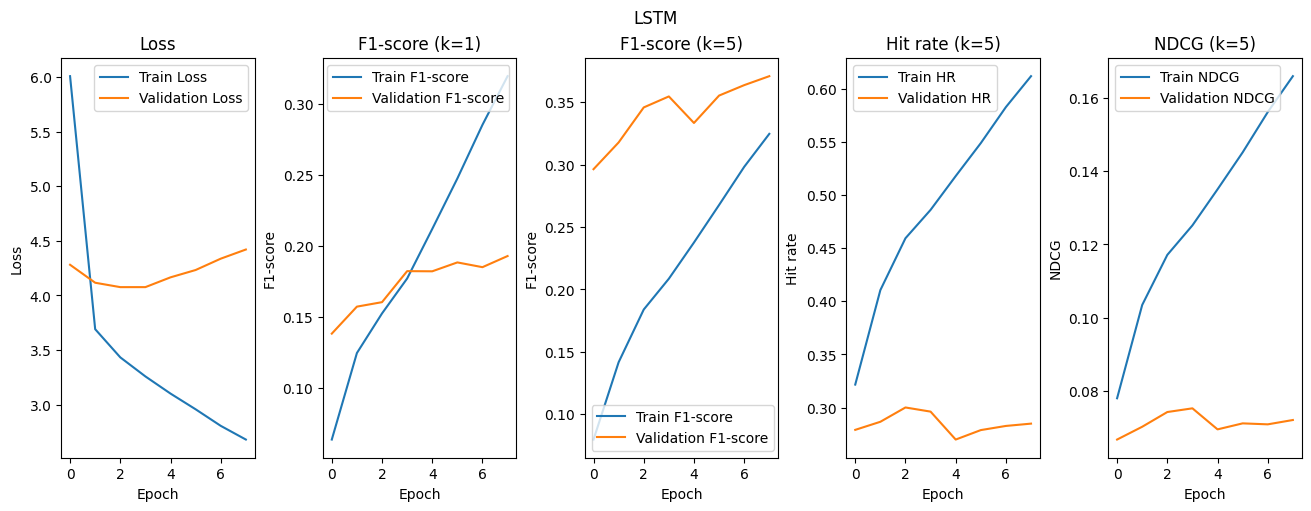

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0731 - f1_score: 0.1072 - f1_score_at_k: 0.2543 - hit_rate_at_k: 0.1809 - loss: 4.8309 - ndcg_at_k: 0.0423
Test loss: 4.3743
Test accuracy: 0.144
Test F1@1: 0.1993
Test F1@5: 0.3674
Test HR@5: 0.2836
Test NDCG@5: 0.0723


In [32]:
parameters

{'user': 'users-3',
 'user_id': 'A21U4DR8M6I9QN',
 'number_of_sequences_and_targets_before_removal': 51055,
 'number_of_sequences_and_targets_after_removal': 50260,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 45756,
 'num_unique_product_ids_in_targets': 179,
 'num_unique_product_ids_in_sequences': 21745,
 'number_of_sequences_and_targets_train': 36581,
 'number_of_sequences_and_targets_validation': 4592,
 'number_of_sequences_and_targets_test': 4583,
 'number_of_unique_products_in_targets_train': 175,
 'number_of_unique_products_in_targets_validation': 178,
 'number_of_unique_products_in_targets_test': 179,
 'model_lstm_test_loss': 4.374271869659424,
 'model_lstm_test_accuracy': 0.144,
 'model_lstm_test_f1_score_k_1': 0.1993,
 'model_lstm_test_f1_score_k_5': 0.3674,
 'model_lstm_test_hr': 0.2836,
 'model_lstm_test_ndcg': 0.0723}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.1435 - f1_score: 0.0610 - f1_score_at_k: 0.1039 - hit_rate_at_k: 0.3853 - loss: 6.7020 - ndcg_at_k: 0.0902 - val_accuracy: 0.1202 - val_f1_score: 0.1342 - val_f1_score_at_k: 0.2537 - val_hit_rate_at_k: 0.2324 - val_loss: 4.2675 - val_ndcg_at_k: 0.0598
Epoch 2/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1653 - f1_score: 0.0977 - f1_score_at_k: 0.1377 - hit_rate_at_k: 0.4098 - loss: 3.6278 - ndcg_at_k: 0.0980 - val_accuracy: 0.1405 - val_f1_score: 0.1583 - val_f1_score_at_k: 0.3283 - val_hit_rate_at_k: 0.2901 - val_loss: 4.1227 - val_ndcg_at_k: 0.0717
Epoch 3/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2120 - f1_score: 0.1372 - f1_score_at_k: 0.1885 - hit_rate_at_k: 0.4695 - loss: 3.3700 - ndcg_at_k: 0.1169 - val_accuracy: 0.1450 - val_f1_score: 0.1796 - val_f1_score_at_k: 0.3518 - val_hit_rate_at_k: 0.2980 - val_loss: 4.0730 - val_ndcg_at_k: 0.0750
Epoch 4/50
1144/1144 ━━━━━━━━━━━━━━━━━

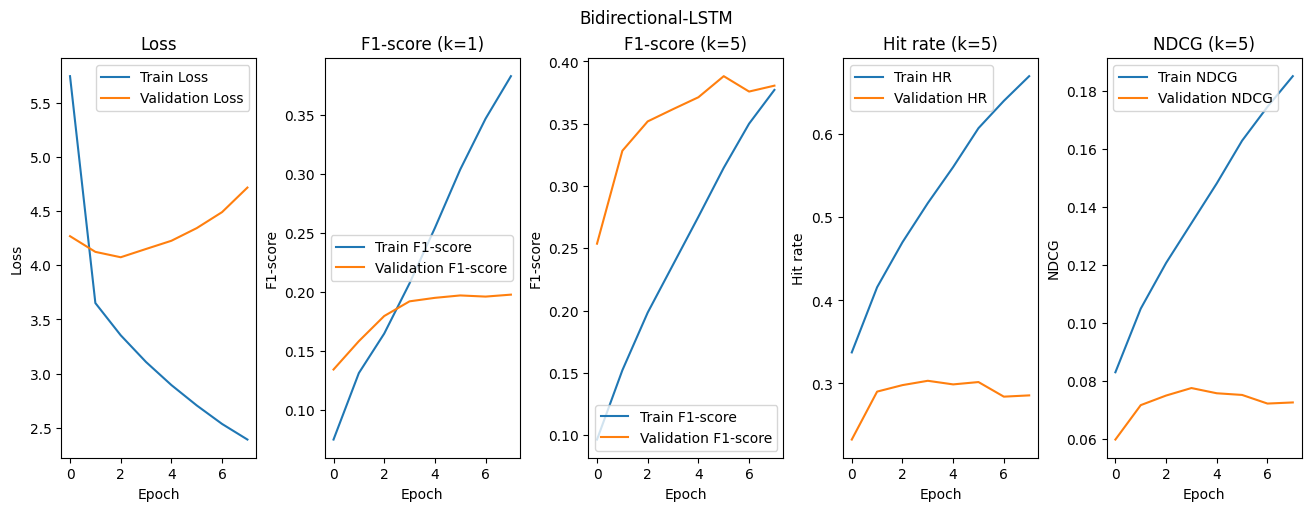

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0683 - f1_score: 0.1005 - f1_score_at_k: 0.2569 - hit_rate_at_k: 0.1777 - loss: 5.1221 - ndcg_at_k: 0.0410
Test loss: 4.6803
Test accuracy: 0.1418
Test F1@1: 0.1981
Test F1@5: 0.374
Test HR@5: 0.2841
Test NDCG@5: 0.0721


In [37]:
parameters

{'user': 'users-3',
 'user_id': 'A21U4DR8M6I9QN',
 'number_of_sequences_and_targets_before_removal': 51055,
 'number_of_sequences_and_targets_after_removal': 50260,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 45756,
 'num_unique_product_ids_in_targets': 179,
 'num_unique_product_ids_in_sequences': 21745,
 'number_of_sequences_and_targets_train': 36581,
 'number_of_sequences_and_targets_validation': 4592,
 'number_of_sequences_and_targets_test': 4583,
 'number_of_unique_products_in_targets_train': 175,
 'number_of_unique_products_in_targets_validation': 178,
 'number_of_unique_products_in_targets_test': 179,
 'model_lstm_test_loss': 4.374271869659424,
 'model_lstm_test_accuracy': 0.144,
 'model_lstm_test_f1_score_k_1': 0.1993,
 'model_lstm_test_f1_score_k_5': 0.3674,
 'model_lstm_test_hr': 0.2836,
 'model_lstm_test_ndcg': 0.0723,
 'model_bi_lstm_test_loss': 4.680251121520996,
 'model_bi_lstm_test_accuracy': 0.1418,
 'model_bi_lstm_test_f1_score_k_1': 0.1

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.1371 - f1_score: 0.0597 - f1_score_at_k: 0.0975 - hit_rate_at_k: 0.3704 - loss: 7.0777 - ndcg_at_k: 0.0866 - val_accuracy: 0.1241 - val_f1_score: 0.1370 - val_f1_score_at_k: 0.2580 - val_hit_rate_at_k: 0.2437 - val_loss: 4.2665 - val_ndcg_at_k: 0.0613
Epoch 2/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1554 - f1_score: 0.0865 - f1_score_at_k: 0.1270 - hit_rate_at_k: 0.3930 - loss: 3.6979 - ndcg_at_k: 0.0935 - val_accuracy: 0.1392 - val_f1_score: 0.1573 - val_f1_score_at_k: 0.3145 - val_hit_rate_at_k: 0.2795 - val_loss: 4.1708 - val_ndcg_at_k: 0.0695
Epoch 3/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1988 - f1_score: 0.1252 - f1_score_at_k: 0.1725 - hit_rate_at_k: 0.4472 - loss: 3.5099 - ndcg_at_k: 0.1107 - val_accuracy: 0.1485 - val_f1_score: 0.1740 - val_f1_score_at_k: 0.3130 - val_hit_rate_at_k: 0.2700 - val_loss: 4.0984 - val_ndcg_at_k: 0.0703
Epoch 4/50
1144/1144 ━━━━━━━━━━━━━━━━━

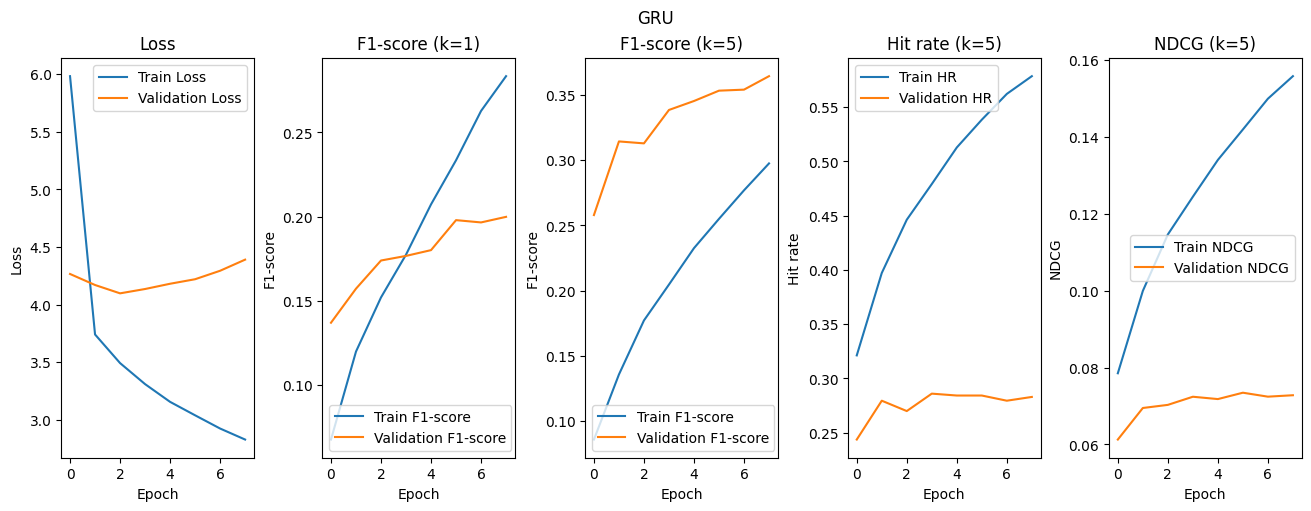

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0640 - f1_score: 0.0904 - f1_score_at_k: 0.2550 - hit_rate_at_k: 0.1778 - loss: 4.8075 - ndcg_at_k: 0.0403
Test loss: 4.321
Test accuracy: 0.1473
Test F1@1: 0.1967
Test F1@5: 0.3643
Test HR@5: 0.283
Test NDCG@5: 0.0725


In [42]:
parameters

{'user': 'users-3',
 'user_id': 'A21U4DR8M6I9QN',
 'number_of_sequences_and_targets_before_removal': 51055,
 'number_of_sequences_and_targets_after_removal': 50260,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 45756,
 'num_unique_product_ids_in_targets': 179,
 'num_unique_product_ids_in_sequences': 21745,
 'number_of_sequences_and_targets_train': 36581,
 'number_of_sequences_and_targets_validation': 4592,
 'number_of_sequences_and_targets_test': 4583,
 'number_of_unique_products_in_targets_train': 175,
 'number_of_unique_products_in_targets_validation': 178,
 'number_of_unique_products_in_targets_test': 179,
 'model_lstm_test_loss': 4.374271869659424,
 'model_lstm_test_accuracy': 0.144,
 'model_lstm_test_f1_score_k_1': 0.1993,
 'model_lstm_test_f1_score_k_5': 0.3674,
 'model_lstm_test_hr': 0.2836,
 'model_lstm_test_ndcg': 0.0723,
 'model_bi_lstm_test_loss': 4.680251121520996,
 'model_bi_lstm_test_accuracy': 0.1418,
 'model_bi_lstm_test_f1_score_k_1': 0.1

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.1122 - f1_score: 0.0668 - f1_score_at_k: 0.1059 - hit_rate_at_k: 0.2600 - loss: 8.7329 - ndcg_at_k: 0.0635 - val_accuracy: 0.1167 - val_f1_score: 0.1362 - val_f1_score_at_k: 0.2793 - val_hit_rate_at_k: 0.2491 - val_loss: 4.3464 - val_ndcg_at_k: 0.0614
Epoch 2/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1510 - f1_score: 0.0877 - f1_score_at_k: 0.1278 - hit_rate_at_k: 0.3867 - loss: 3.7616 - ndcg_at_k: 0.0916 - val_accuracy: 0.1324 - val_f1_score: 0.1486 - val_f1_score_at_k: 0.3081 - val_hit_rate_at_k: 0.2823 - val_loss: 4.1819 - val_ndcg_at_k: 0.0685
Epoch 3/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1789 - f1_score: 0.1098 - f1_score_at_k: 0.1572 - hit_rate_at_k: 0.4269 - loss: 3.6384 - ndcg_at_k: 0.1038 - val_accuracy: 0.1407 - val_f1_score: 0.1593 - val_f1_score_at_k: 0.3297 - val_hit_rate_at_k: 0.2856 - val_loss: 4.1345 - val_ndcg_at_k: 0.0707
Epoch 4/50
1144/1144 ━━━━━━━━━━━━━━━━━

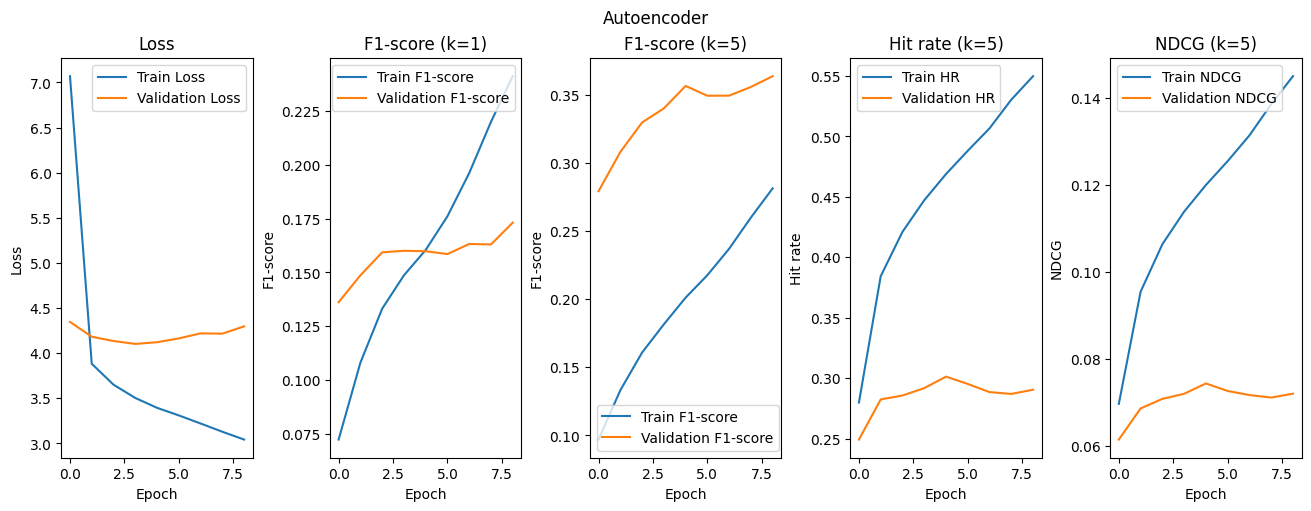

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0500 - f1_score: 0.0658 - f1_score_at_k: 0.2306 - hit_rate_at_k: 0.1681 - loss: 4.7207 - ndcg_at_k: 0.0365
Test loss: 4.2585
Test accuracy: 0.1364
Test F1@1: 0.1728
Test F1@5: 0.3595
Test HR@5: 0.287
Test NDCG@5: 0.0719


In [47]:
parameters

{'user': 'users-3',
 'user_id': 'A21U4DR8M6I9QN',
 'number_of_sequences_and_targets_before_removal': 51055,
 'number_of_sequences_and_targets_after_removal': 50260,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 45756,
 'num_unique_product_ids_in_targets': 179,
 'num_unique_product_ids_in_sequences': 21745,
 'number_of_sequences_and_targets_train': 36581,
 'number_of_sequences_and_targets_validation': 4592,
 'number_of_sequences_and_targets_test': 4583,
 'number_of_unique_products_in_targets_train': 175,
 'number_of_unique_products_in_targets_validation': 178,
 'number_of_unique_products_in_targets_test': 179,
 'model_lstm_test_loss': 4.374271869659424,
 'model_lstm_test_accuracy': 0.144,
 'model_lstm_test_f1_score_k_1': 0.1993,
 'model_lstm_test_f1_score_k_5': 0.3674,
 'model_lstm_test_hr': 0.2836,
 'model_lstm_test_ndcg': 0.0723,
 'model_bi_lstm_test_loss': 4.680251121520996,
 'model_bi_lstm_test_accuracy': 0.1418,
 'model_bi_lstm_test_f1_score_k_1': 0.1

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A21U4DR8M6I9QN', 'sequence': [114193, 90069], 'target': 95644}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 1.0
NDCG@50: 0.016910282894968987
-------------
HT@100: 1.0
NDCG@100: 0.010416338220238686
-------------
HT@200: 1.0
NDCG@200: 0.006264112889766693
-------------
HT@300: 1.0
NDCG@300: 0.004603409208357334
-------------
HT@400: 1.0
NDCG@400: 0.0036834445782005787
-------------
HT@500: 1.0
NDCG@500: 0.003091187449172139
-------------
